In [1]:
from functools import reduce
import sqlite3
import warnings
warnings.filterwarnings("ignore")

from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

In [2]:
def run_RF_classifier(X_train, y_train,
                       X_test,
                       **kwargs):
    clf = RandomForestClassifier(**kwargs)
    clf.fit(X_train, y_train)
    predictions_proba = clf.predict_proba(X_test)
    predict = clf.predict(X_test)
    return predictions_proba, predict


def run_k_fold_split(features, targets, n_splits=10, random_state=0,
                     **kwargs):

    res_predict_proba = np.empty(len(features))
    res_predict = np.empty(len(features))
    res_predict_proba[:] = np.nan
    res_predict[:] = np.nan

    sss = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    sss.get_n_splits(features, targets)
    for train_index, test_index in sss.split(features, targets):
        X_train, X_test, y_train = \
            features.iloc[train_index], \
            features.iloc[test_index], \
            targets.iloc[train_index]

        predict_proba, predict = run_RF_classifier(X_train, y_train, X_test,
                                                    **kwargs)
        predict_proba = predict_proba.T[1]

        res_predict_proba[test_index] = predict_proba
        res_predict[test_index] = predict
    return res_predict, res_predict_proba


def ROC_curve(df, method):
    conf_matrix = pd.DataFrame(columns=['TN','FN','FP','TP'])
    for i in np.arange(0.00,1.01,0.01): 
        df[method+"_threshold"] = np.where(df[method+"_"+"prob"]>= i, 1.0, df[method+"_"+"prob"])
        df[method+"_threshold"] = np.where(df[method+"_threshold"]!=1.0, 0.0, df[method+"_threshold"])
        FOMs = {0+0j:'TN', 1+0j:'FN',0+1j:'FP',1+1j:'TP'}
        winner_complex = df["has_mass_gap"] + 1j * df[method+"_threshold"]
        df["classified"] = winner_complex
        FOM_map = map (lambda x: FOMs[x], winner_complex) 
        df["classified"] = list(FOM_map)
        conf_matrix= conf_matrix.append(df["classified"].value_counts())
    conf_matrix = conf_matrix.reset_index(drop=True)
    conf_matrix = conf_matrix.fillna(0).astype(int)   
    conf_matrix['TPR'] = conf_matrix['TP']/(conf_matrix['TP']+conf_matrix['FN'])
    conf_matrix['TNR'] = conf_matrix['TN']/(conf_matrix['TN']+conf_matrix['FP'])
    conf_matrix['FNR'] = conf_matrix['FN']/(conf_matrix['FN']+conf_matrix['TP'])
    conf_matrix['FPR'] = conf_matrix['FP']/(conf_matrix['FP']+conf_matrix['TN'])
    conf_matrix['Threshold'] = np.arange(0.00,1.01,0.01)
    return conf_matrix

# Datasets

## Rates

In [3]:
# rates dataset
df_rates = pd.read_csv('em-bright-rates-injections.tbl', delimiter='\t')
df_rates = df_rates.loc[df_rates.cfar < 1/(30 * 864600)]
df_rates.describe()

inj_mass2_source_frame  inj_mass1_source_frame             id  \
count           182707.000000           182707.000000  182707.000000   
mean                17.721550                8.576530  298693.665289   
std                 15.706273               12.981296  173408.368482   
min                  0.800100                0.800130       1.000000   
25%                  5.000000                1.400000  151630.500000   
50%                 10.000004                1.400001  295159.000000   
75%                 29.999996               10.217106  449817.500000   
max                 99.986827               49.998659  602080.000000   

              inj_m1         inj_m2     inj_spin1z     inj_spin2z  \
count  182707.000000  182707.000000  182707.000000  182707.000000   
mean       10.284702      19.927525       0.026898       0.113441   
std        16.339524      18.296016       0.288988       0.461598   
min         0.806347       0.806887      -0.989799      -0.989963   
25%         1.444279       5.189927      -0.030415      -0.131037   
50%         1.491348      10.673407       0.001313       0.041691   
75%        11.444879      31.462311       0.041356       0.455494   
max        83.205907     118.848530       0.990000       0.989978   

        inj_redshift         rec_m1         rec_m2     rec_spin1z  \
count  182707.000000  182707.000000  182707.000000  182707.000000   
mean        0.086551      24.067393       6.204259       0.123434   
std         0.096399      22.385729       8.854361       0.523016   
min         0.000107       1.005567       1.000001      -0.998992   
25%         0.028999       5.318224       1.230952      -0.158926   
50%         0.048253      16.432117       1.688804       0.133851   
75%         0.099158      39.967640       6.471844       0.535135   
max         0.699638     381.369900      67.166664       0.998999   

          rec_spin2z         Gamma1           cfar            snr  \
count  182707.000000  182707.000000   1.827070e+05  182707.000000   
mean       -0.047889     440.905258   1.545018e-09      14.138595   
std         0.386420     197.697113   5.340386e-09       7.946113   
min        -0.999000       0.000000  8.327518e-158       8.676703   
25%        -0.047041     309.000000   1.097704e-27      10.509667   
50%        -0.002236     539.000000   8.693846e-18      11.904672   
75%         0.038878     623.000000   1.682015e-11      14.839015   
max         0.998962     681.000000   3.854592e-08     922.666136   

            gpstime  
count  1.827070e+05  
mean   1.175389e+09  
std    5.442817e+06  
min    1.164601e+09  
25%    1.171349e+09  
50%    1.174638e+09  
75%    1.181150e+09  
max    1.185212e+09

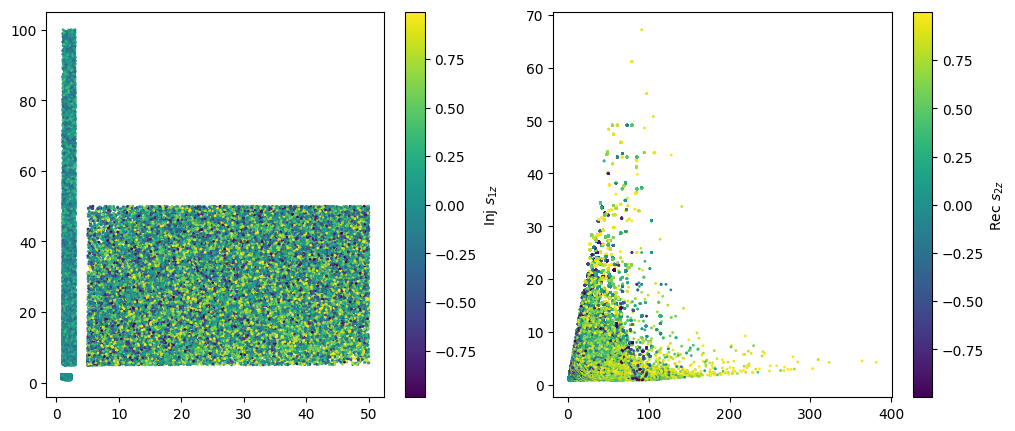

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
c1 = ax1.scatter(df_rates.inj_mass1_source_frame, df_rates.inj_mass2_source_frame, s=1, c=df_rates.inj_spin1z)
plt.colorbar(c1, label='Inj $s_{1z}$', ax=ax1)
c2 = ax2.scatter(df_rates.rec_m1, df_rates.rec_m2, s=1, c=df_rates.rec_spin1z)
plt.colorbar(c2, label='Rec $s_{2z}$', ax=ax2)

## Reweighted

In [5]:
df_reweighted = pd.read_csv('em-bright-reweighted-injections.tbl', delimiter='\t')
df_reweighted = df_reweighted.loc[df_reweighted.cfar < 1/(30 * 864600)]
df_reweighted.describe()

inj_mass2_source_frame  inj_mass1_source_frame             id  \
count            86880.000000            86880.000000   86880.000000   
mean                19.711878               12.168511   72756.694279   
std                 18.840809               14.828395   41878.312956   
min                  0.800079                0.800569       0.000000   
25%                  2.516620                1.898659   36837.500000   
50%                 14.961260                2.686628   72674.500000   
75%                 32.177844               22.252791  108789.250000   
max                 99.952250               49.997470  145652.000000   

             inj_m1        inj_m2    inj_spin1z    inj_spin2z  inj_redshift  \
count  86880.000000  86880.000000  86880.000000  86880.000000  86880.000000   
mean      14.556853     22.488453      0.019148      0.052608      0.100808   
std       18.526687     21.549300      0.232783      0.288636      0.104106   
min        0.804632      0.803753     -0.982209     -0.988058      0.000537   
25%        1.971432      2.598694     -0.087494     -0.088077      0.030099   
50%        2.809064     16.498130      0.004010      0.016482      0.054644   
75%       26.180395     37.458026      0.117238      0.185381      0.141360   
max       81.940697    114.706110      0.979574      0.986946      0.697334   

             rec_m1        rec_m2    rec_spin1z    rec_spin2z        Gamma1  \
count  86880.000000  86880.000000  86880.000000  86880.000000  86880.000000   
mean      29.077846      8.228190      0.079974     -0.081993    457.570246   
std       27.955124      9.776811      0.467471      0.430923    212.533241   
min        1.001285      1.000005     -0.998966     -0.998918      0.000000   
25%        3.984652      1.339182     -0.129582     -0.296872    267.000000   
50%       24.427246      2.394881      0.130552     -0.013541    595.000000   
75%       47.117332     13.902986      0.397417      0.042737    627.000000   
max      393.420040     61.151516      0.998795      0.998978    681.000000   

                cfar           snr       gpstime  
count   8.688000e+04  86880.000000  8.688000e+04  
mean    1.601682e-09     14.292678  1.175372e+09  
std     5.467848e-09      7.931350  5.417946e+06  
min    6.627289e-167      8.524042  1.164601e+09  
25%     4.031082e-27     10.602396  1.171353e+09  
50%     1.741592e-17     12.024696  1.174627e+09  
75%     2.009183e-11     15.046051  1.181117e+09  
max     3.854067e-08    376.745744  1.185212e+09

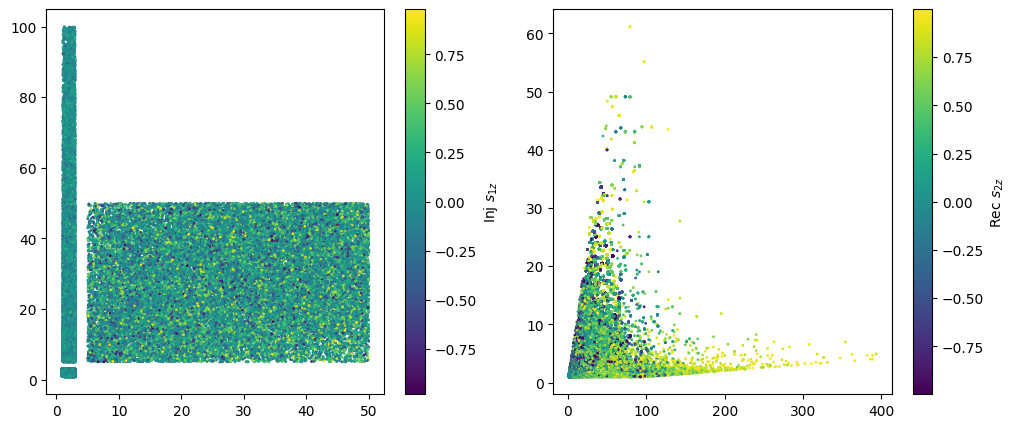

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
c1 = ax1.scatter(df_reweighted.inj_mass1_source_frame, df_reweighted.inj_mass2_source_frame,
                 s=1, c=df_reweighted.inj_spin1z)
plt.colorbar(c1, label='Inj $s_{1z}$', ax=ax1)
c2 = ax2.scatter(df_reweighted.rec_m1, df_reweighted.rec_m2, s=1, c=df_reweighted.rec_spin1z)
plt.colorbar(c2, label='Rec $s_{2z}$', ax=ax2)

In [7]:
df_mass_gap = pd.read_csv('massgap.csv')
df_mass_gap = df_mass_gap.loc[df_mass_gap.cfar < 1/(30 * 864600)]
df_mass_gap.describe()

inj_mass2_source_frame  inj_mass1_source_frame            id  \
count            34330.000000            34330.000000  34330.000000   
mean                 8.816584                3.323905  49763.085377   
std                 10.529394                1.168517  27203.694720   
min                  1.002118                1.399999    516.000000   
25%                  4.000000                1.400001  26465.250000   
50%                  4.000002                3.999999  50584.500000   
75%                 10.000000                4.000001  72690.750000   
max                 99.534976                4.999937  98226.000000   

             inj_m1        inj_m2    inj_spin1z    inj_spin2z  inj_redshift  \
count  34330.000000  34330.000000  34330.000000  34330.000000  34330.000000   
mean       3.529242      9.399022      0.010627      0.049428      0.056942   
std        1.269989     11.325713      0.384454      0.451520      0.030913   
min        1.402106      1.030924     -0.989329     -0.989716      0.001504   
25%        1.485884      4.150061     -0.137147     -0.228366      0.033767   
50%        4.180597      4.293810      0.001161      0.030839      0.051071   
75%        4.307656     10.707421      0.170752      0.355604      0.074693   
max        5.926733    113.266140      0.989868      0.989944      0.199386   

             rec_m1        rec_m2    rec_spin1z    rec_spin2z        Gamma1  \
count  34330.000000  34330.000000  34330.000000  34330.000000  34330.000000   
mean      16.454597      2.582062      0.271318     -0.017094    470.091349   
std       20.909082      1.491992      0.472510      0.422398    130.453507   
min        2.029389      1.000040     -0.999000     -0.998984    122.000000   
25%        5.722519      1.473903     -0.008750     -0.132250    283.000000   
50%        9.718011      2.146527      0.366221     -0.003242    474.000000   
75%       19.467861      3.300823      0.651272      0.048626    586.000000   
max      393.420040     32.327995      0.998975      0.998946    681.000000   

                cfar           snr       gpstime  
count   3.433000e+04  34330.000000  3.433000e+04  
mean    1.426265e-09     14.009043  1.180964e+09  
std     5.127437e-09      7.716890  7.029231e+06  
min    5.536083e-204      8.435111  1.169210e+09  
25%     1.891197e-26     10.404383  1.172773e+09  
50%     7.689866e-18     11.806983  1.185952e+09  
75%     5.387357e-12     14.761018  1.186660e+09  
max     3.851020e-08    314.103882  1.187312e+09

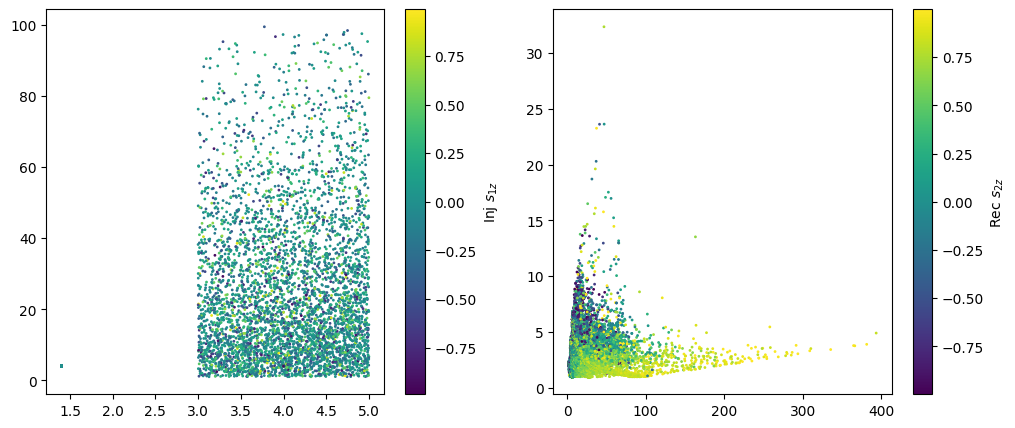

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
c1 = ax1.scatter(df_mass_gap.inj_mass1_source_frame, df_mass_gap.inj_mass2_source_frame,
                 s=1, c=df_mass_gap.inj_spin1z)
plt.colorbar(c1, label='Inj $s_{1z}$', ax=ax1)
c2 = ax2.scatter(df_mass_gap.rec_m1, df_mass_gap.rec_m2, s=1, c=df_mass_gap.rec_spin1z)
plt.colorbar(c2, label='Rec $s_{2z}$', ax=ax2)

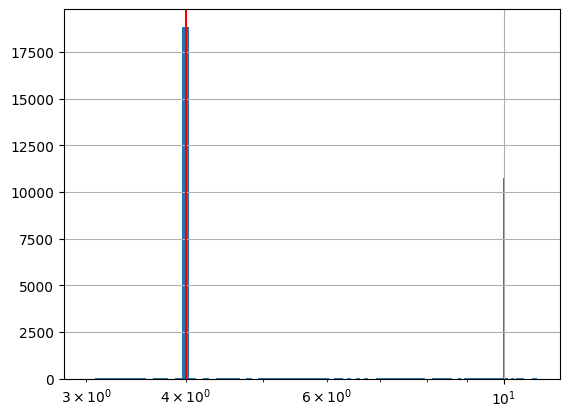

In [9]:
df_mass_gap.inj_mass2_source_frame.hist(bins=100, range=(3, 11))
plt.xscale('log')
plt.axvline(x=4, c='r')
# plt.axvline(x=10., c='r')

In [10]:
mask = (df_mass_gap.inj_mass2_source_frame < 4.001) & (df_mass_gap.inj_mass2_source_frame > 3.999)
mask += (df_mass_gap.inj_mass2_source_frame < 10.001) & (df_mass_gap.inj_mass2_source_frame > 9.999)

In [11]:
np.sum(mask)

29596

In [12]:
df_mass_gap = df_mass_gap.loc[~mask]

Text(0.5, 0, 'Inj mass2 after Delta function removal')

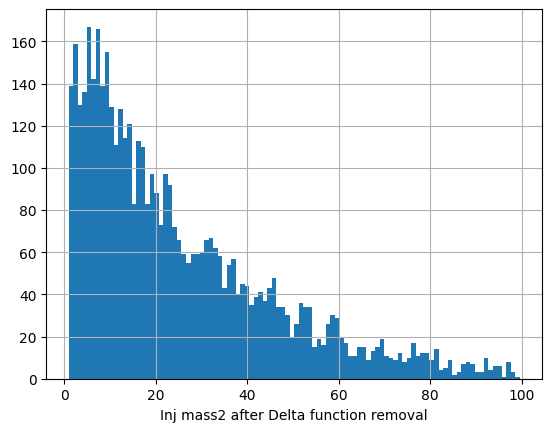

In [13]:
df_mass_gap.inj_mass2_source_frame.hist(bins=100)
plt.xlabel("Inj mass2 after Delta function removal")

## MDC 

In [14]:
filename = "MDC6_1343328000_1346784000.sqlite"
with sqlite3.connect(filename) as conn:
    df_mdc = pd.read_sql_query(" SELECT * FROM events", conn)

In [15]:
df_mdc = df_mdc.loc[df_mdc.combined_far < 1./(30 * 86400)]

df_mdc['snr'] = df_mdc['combined_snr']

df_mdc['rec_m1'] = df_mdc['mass1']
df_mdc['rec_m2'] = df_mdc['mass2']
df_mdc['inj_spin1z'] = df_mdc['spin1z_inj']
df_mdc['inj_spin2z'] = df_mdc['spin2z_inj']
df_mdc['rec_spin1z'] = df_mdc['spin1z']
df_mdc['rec_spin2z'] = df_mdc['spin2z']

df_mdc['inj_mass1_source_frame'] = df_mdc['mass1_inj']/(1 + df_mdc['z_inj'])
df_mdc['inj_mass2_source_frame'] = df_mdc['mass2_inj']/(1 + df_mdc['z_inj'])
df_mdc['mc_rec'] = (df_mdc.mass1 * df_mdc.mass2)**(3./5.)/(df_mdc.mass1 + df_mdc.mass2)**(1./5.)
df_mdc['mtot_rec'] = df_mdc.mass1 + df_mdc.mass2

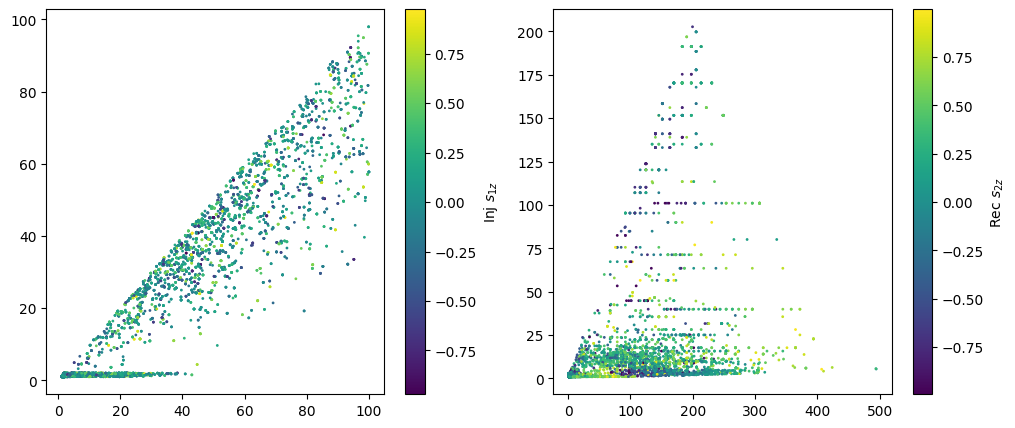

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
c1 = ax1.scatter(df_mdc.inj_mass1_source_frame, df_mdc.inj_mass2_source_frame,
                 s=1, c=df_mdc.inj_spin1z)
plt.colorbar(c1, label='Inj $s_{1z}$', ax=ax1)
c2 = ax2.scatter(df_mdc.rec_m1, df_mdc.rec_m2, s=1, c=df_mdc.rec_spin1z)
plt.colorbar(c2, label='Rec $s_{2z}$', ax=ax2)

# Notes

- Very dense injection at 4 and 10 sol masses in the mass gap injection set from O2.

- Recovery bank in the O3 injection MDC is broader compared to O2 - the axes in the recovery panel extend to larger intervals compared to the O2 data.

# O2 Rates + Reweighted + Mass Gap Training

In [17]:
common_keys = reduce(
    lambda x, y: x.intersection(y),
    (df_rates.keys(), df_reweighted.keys(), df_mass_gap.keys())
)

df_no_mass_gap = pd.concat((df_rates.loc[:, common_keys], df_reweighted.loc[:, common_keys]), ignore_index=True)
df_mass_gap = df_mass_gap.loc[:, common_keys]

In [18]:
def has_mass_gap(df):
    mask = (df.inj_mass1_source_frame > 3) & (df.inj_mass1_source_frame < 5)
    mask += (df.inj_mass2_source_frame > 3) & (df.inj_mass2_source_frame < 5)
    
    return mask

In [19]:
df_no_mass_gap['has_mass_gap'] = has_mass_gap(df_no_mass_gap).astype(int)
df_mass_gap['has_mass_gap'] = has_mass_gap(df_mass_gap).astype(int)

In [20]:
print("Net Mass gap labels = ", df_no_mass_gap.has_mass_gap.sum() + df_mass_gap.has_mass_gap.sum())

Net Mass gap labels =  16598


In [21]:
df_training = pd.concat((df_no_mass_gap, df_mass_gap), ignore_index=True)

In [22]:
print("Total size Mass Gap + No mass gap = ", len(df_training))

Total size Mass Gap + No mass gap =  274321


In [23]:
df_training.keys()

Index(['inj_mass2_source_frame', 'inj_mass1_source_frame', 'id', 'inj_m1',
       'inj_m2', 'inj_spin1z', 'inj_spin2z', 'inj_redshift', 'rec_m1',
       'rec_m2', 'rec_spin1z', 'rec_spin2z', 'Gamma1', 'cfar', 'snr',
       'gpstime', 'has_mass_gap'],
      dtype='object')

In [24]:
col_names = 'rec_m1,rec_m2,rec_spin1z,rec_spin2z,snr'
features_cols = col_names.split(',')

features = df_training[features_cols]
targets = df_training.has_mass_gap
features.head()

rec_m1    rec_m2  rec_spin1z  rec_spin2z        snr
0  1.875691  1.111429    0.016153   -0.004930  10.256170
1  1.790411  1.164473   -0.013942    0.049995  13.862971
2  1.578616  1.303211   -0.020972   -0.001414  10.948051
3  1.730058  1.192073    0.030279   -0.003580  14.038067
4  2.089142  1.011998   -0.318992   -0.016708  22.223619

In [25]:
rf_kwargs = dict(max_features=None, max_depth=70, min_samples_leaf=5, n_splits=10, n_jobs=8)

rf_predict, rf_predict_proba = run_k_fold_split(features, targets, **rf_kwargs)

In [26]:
df_training['rf_prob'] = rf_predict_proba

Text(0.5, 1.0, 'ROC_curve for RF hasmassgap')

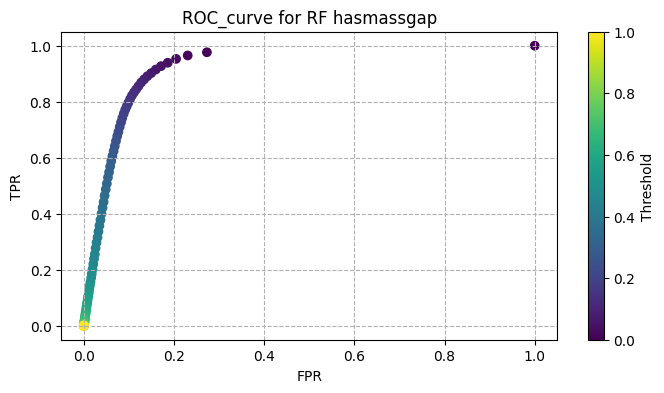

In [27]:
has_mass_gap_conf_matrix_rf = ROC_curve(df_training,"rf")
fig, ax = plt.subplots(figsize=(8,4))
im1 = ax.scatter(has_mass_gap_conf_matrix_rf['FPR'],has_mass_gap_conf_matrix_rf['TPR'],
                 c=has_mass_gap_conf_matrix_rf['Threshold'])
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
# ax.set_xlim(0.00,0.25)
# ax.set_ylim(0.80,1.01)
cbar = fig.colorbar(im1)
cbar.set_label("Threshold")
ax.grid(linestyle = "--")
ax.set_title("ROC_curve for RF hasmassgap")

# Grid search

In [28]:
%%time

grid_search_params = {
    'max_features': [None, 'sqrt'],
    'max_depth': [20, 70],
    'min_samples_leaf': [1, 10],
    'min_samples_split': [2, 10]
}
rf_clf = RandomForestClassifier()
grid_search_cv = GridSearchCV(rf_clf, grid_search_params, verbose=3, n_jobs=8)
grid_search_cv.fit(features, targets)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 37.8 s, sys: 216 ms, total: 38 s
Wall time: 20min 10s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [20, 70], 'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 10],
                         'min_samples_split': [2, 10]},
             verbose=3)

In [29]:
grid_search_cv.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [30]:
grid_search_cv.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=10)

# Parameter Sweep

In [31]:
mass1 = np.linspace(1, 400, 1000)
mass2 = np.linspace(1, 400, 1000)

spins = Table(data=np.vstack((np.repeat(np.linspace(0, 1, 2), 2),
              np.tile(np.linspace(0, 1, 2), 2))).T,
              names=('chi1', 'chi2'))

t = Table(data=np.vstack((np.repeat(mass1, mass2.size),
                          np.tile(mass2, mass1.size))).T, names=('mass1', 'mass2'))

mask = t['mass1'] > t['mass2']

t = t[mask]

signal_to_noise = [10,]

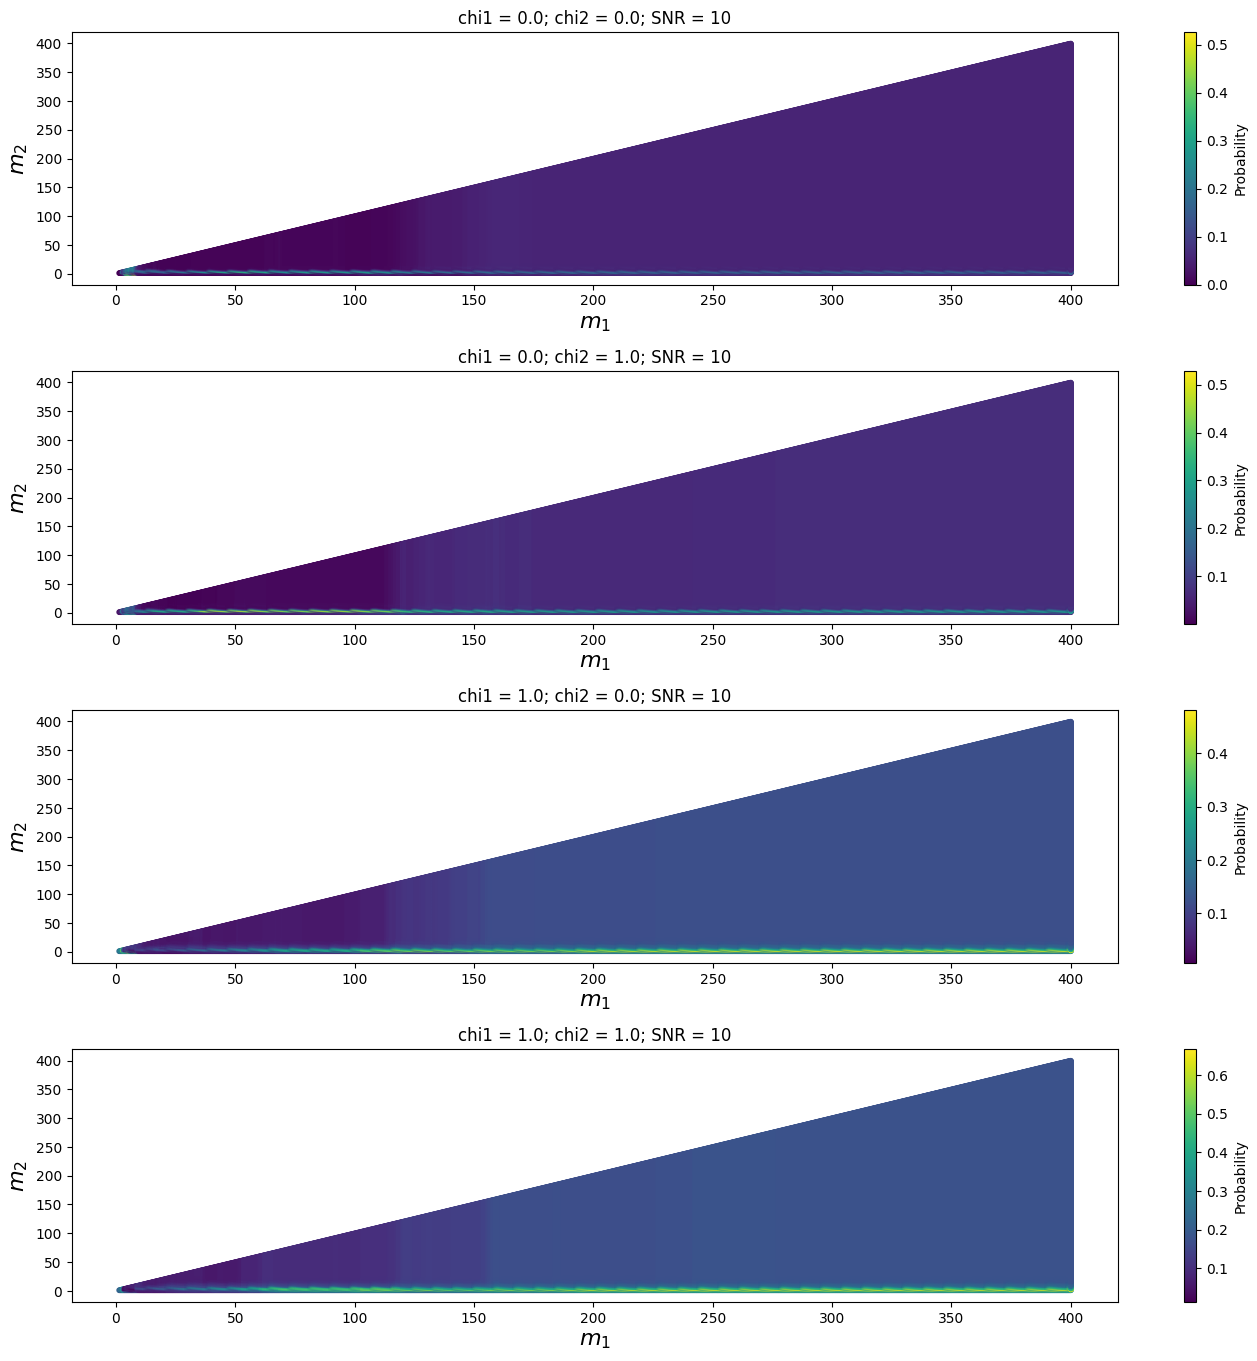

In [32]:
def make_plots(features, predictions, title, fig_idx):
    fig_, idx = fig_idx
    fig_.add_subplot(6, 1, idx)
    # indices 0 and 1 correspond to mass1 and mass2 respectively
    plt.scatter(features.T[0], features.T[1],
                s=10, c=predictions)
    plt.title(title)
    plt.tight_layout()
    plt.colorbar(label='Probability')

    plt.xlabel(r'$m_1$', fontsize=16)
    plt.ylabel(r'$m_2$', fontsize=16)
    plt.title(title)

fig = plt.figure(figsize=(14, 20))

for idx, spin_vals in enumerate(spins):
    SNR = np.random.choice(signal_to_noise)
    title = "chi1 = {0}; chi2 = {1}; SNR = {2}".format(spin_vals['chi1'],
                                                       spin_vals['chi2'],
                                                       SNR)
    SNR *= np.ones(np.sum(mask))
    chi1 = spin_vals['chi1'] * np.ones(np.sum(mask))
    chi2 = spin_vals['chi2'] * np.ones(np.sum(mask))

    # make predictions and make plots
    param_sweep_features = np.stack([t['mass1'], t['mass2'], chi1, chi2, SNR]).T
    mass_gap_predictions = grid_search_cv.best_estimator_.predict_proba(param_sweep_features).T[1]
    # plot against m1-m2 the non-zero p-values
    mass_gap_mask = mass_gap_predictions >= 0.
    make_plots(param_sweep_features[mass_gap_mask], mass_gap_predictions[mass_gap_mask],
               title, (fig, idx+1))

# Results on MDC

In [33]:
df_mdc['has_mass_gap'] = has_mass_gap(df_mdc)

In [34]:
required_data = df_mdc.loc[:,features_cols]

In [35]:
df_mdc['rf_prob'] = grid_search_cv.best_estimator_.predict_proba(required_data)[:,1]

Text(0.5, 1.0, 'ROC_curve for RF hasmassgap on MDC')

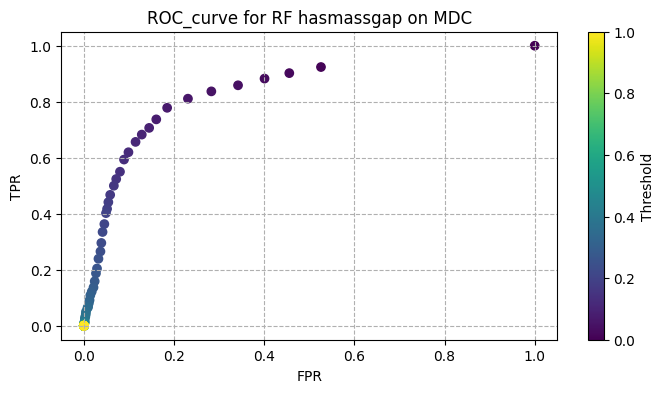

In [36]:
temp = df_mdc.copy()

has_mass_gap_conf_matrix_rf = ROC_curve(temp,"rf")
fig, ax = plt.subplots(figsize=(8,4))
im1 = ax.scatter(has_mass_gap_conf_matrix_rf['FPR'],has_mass_gap_conf_matrix_rf['TPR'],
                 c=has_mass_gap_conf_matrix_rf['Threshold'])
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
# ax.set_xlim(0.00,0.25)
# ax.set_ylim(0.80,1.01)
cbar = fig.colorbar(im1)
cbar.set_label("Threshold")
ax.grid(linestyle = "--")
ax.set_title("ROC_curve for RF hasmassgap on MDC")